In [2]:
%matplotlib inline

import os,sys,inspect
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

import sklearn.metrics as sk_metrics

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from model.model_util import *

warnings.filterwarnings('ignore')


In [3]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

In [4]:
# load data

with open("../data/top_5_contacts_cal.df", "rb") as raw_file:
    top_5_raw_df = pickle.load(raw_file)
    
with open("../data/coe_contact_all.df", "rb") as raw_file:
    all_raw_df = pickle.load(raw_file)

with open('../data/demographics.df', 'rb') as demo_file:
    demo_df = pickle.load(demo_file)
demo_cols = ['pid', 'age', 'gender', 'education', 'employment', 'live_together', 'race', 'ethnicity', 'marital_status']

In [26]:
def print_ensemble(ensemble, latex=False):
    delim = ","
    end = ""
    for weight, pipeline in ensemble:
        if latex:
            print("{} & {} \\\\".format(weight, 
                                        pipeline.configuration['classifier:__choice__']))
        else:
            print("Weight: {}, classifier: {}".format(weight, 
                                                      pipeline.configuration['classifier:__choice__']))
            
            
def plot_results(rf_test_scores, automl_test_scores, majority_score, y_label, title):
    x = np.arange(0,5)
    width = 0.35
    plt.rcParams["figure.figsize"] = [12,6]
    ax = plt.bar(x-(width/2), rf_test_scores, width, label='random forest')
    annotate_bar(ax)
    ax = plt.bar(x+(width/2), automl_test_scores, width, label='auto-sklearn')
    annotate_bar(ax)
    
    plt.axhline(y=majority_score, color='black', ls='dotted', label='majority')
    plt.yticks(np.arange(0.25, 0.8, 0.05))
    plt.ylabel(y_label)
    plt.xlabel("Features")
    plt.xticks(x, ['baseline', 'age/sex', 'all demographics', 'location', 'all'])
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
            
        
def annotate_bar(ax):
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()
        sign = np.sign(height)
        text = format(height, ".3f")
        plt.text((bar.get_x() + bar.get_width()/2), height*1.01, text, ha='center')            

# Measuring Relationships and their Meaning from Phone Data

## Motivation

### Field domain
- social relationships and communication tie strength
- passive mobile device sensing
- ML for life-facet prediction (Zimmerman group)

## The gap we fill

- use of additional phone sensor data to contextualize communication
- user of AutoML to remove engineering bias in model choice/performance tuning
- finer grained social relationship role prediction

## Methods: raw features

### Communication logs

- SMS, call logs: incoming, outgoing, missed, timestamp
- call duration (no text length)
- 406,317 communication events and 9,645 EMA contact information collected

![](../tex/figures/call_trend.png)


### Survey data: contact type

|Question/measure label | Response range|
|-|-|
|contact_type |	{Significant Other, Friend, Family Member You Live With, Family Member You Don't Live With, Colleague/Work-Related, Task (e.g. Make an Appointment, Reservation, etc.), Other}|
|want_question |	{1 (Not At All), 2, 3, 4 (Some), 5, 6, 7 (Extremely Close)}|
|talk_question |	{1 (Strongly Disagree), 2 (Disagree), 3 (Somewhat Disagree), 4 (Neither Agree Or Disagree), 5 (Somewhat Agree), 6 (Agree), 7 (Strongly Agree)}|
|loan_question |	{1 (Strongly Disagree), 2 (Disagree), 3 (Somewhat Disagree), 4 (Neither Agree Or Disagree), 5 (Somewhat Agree), 6 (Agree), 7 (Strongly Agree)} |
|closeness |	{1 (Not At All), 2, 3, 4 (Some), 5, 6, 7 (Extremely Close)} |


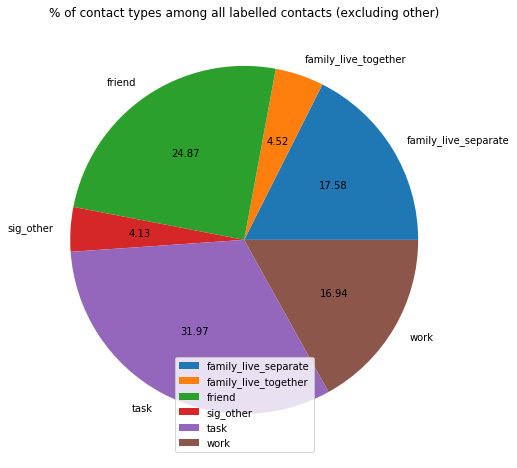

In [6]:
all_types = all_raw_df.loc[all_raw_df['contact_type'] != 'other']
all_types = all_types.drop_duplicates('combined_hash').groupby('contact_type').count()
all_types.plot.pie('comm_type', autopct='%.2f', figsize=(8,8))
plt.title('% of contact types among all labelled contacts (excluding other)')
plt.legend(loc='lower center')
plt.ylabel("")
plt.show()

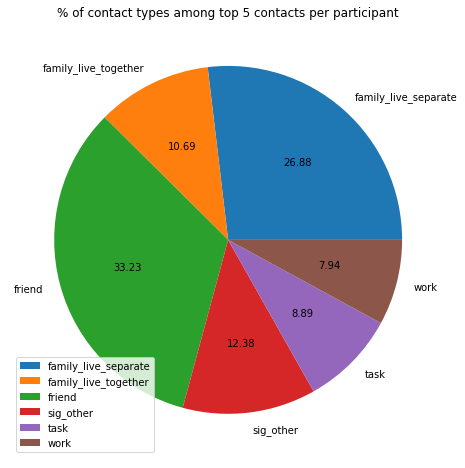

In [7]:
top_types = top_5_raw_df.drop_duplicates('combined_hash').groupby('contact_type').count()
top_types.plot.pie('comm_type', autopct='%.2f', figsize=(8,8))
plt.title('% of contact types among top 5 contacts per participant')
plt.legend(loc='lower left')
plt.ylabel("")
plt.show()

### Demographics

| label | item |
|-------|------|
|demo08	| Birthdate|
|demo09 |Gender |
|demo09_oth |Other|
|demo10_1  |How do you define your race? Black or African American (Having origins in any of the black racial groups of Africa)|
|demo10_2 |How do you define your race? American Indian (North; South or Central) or Alaska Native (Having origins in any of the original peoples of North; Central or South America)|
|demo10_3 |How do you define your race? Asian (Having origins in any of the original peoples of the Far East; Southeast Asia; or the Indian Subcontinent. For example: Cambodia; China; India; Japan; Korea; Malaysia; Pakistan; the Philippine Islands; Thailand; and Vietnam)|
|demo10_4 | How do you define your race? Native Hawaiian or Other Pacific Islander (Having origins in any of the original peoples of Hawaii; Guam; Samoa or other Pacific Islands)|
|demo10_5 |How do you define your race? White (Having origins in any of the original peoples of Europe; the Middle East; or North Africa) |
|demo10_6 |How do you define your race? Prefer not to answer |
|demo11	|What is your ethnic identity? |
|demo12 |What is the highest level of education you have received?
|demo13	|Please select your most current marital status|
|demo14	|Do you live with others?|

- age
- gender
- race
- education
- marital status

- living with others
- employment status

In [8]:
# TODO drop in demographic features

### Semantic location

- TODO Sohrab's chart

## Methods: feature extraction

### Intensity and regularity
- \# days {call, sms} / days logged
- {avg, std, min, max, med} {out, in} {call, sms} per day
- {avg, max} call duration

### Temporal tendency
- \# {call, sms} at {time of day, day of week} / total

### Channel selection
- out comm / total comm
- \# calls / total comm
    
### Avoidance
- missed calls / {out, in} calls
- in SMS / out SMS

## Methods: AutoML

- TODO paste in points from Overleaf
- four blocks of information:
    - communication features
    - age/sex
    - age/sex + demographics
    - location
    

## Results: 6-class relationship prediction

In [9]:
features = ['baseline', 'age_gender', 'demo', 'loc', 'all']

replace_dict = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "task": 2,
        "family_live_separate": 3,
        "family_live_together": 4,
        "sig_other": 5
    }
}

contact_types = list(replace_dict['contact_type'].keys())

# load data
top_5_baseline_train = pickle.load(open('../data/rd2_features/top_5_baseline_train_features.df', 'rb'))
top_5_baseline_test =  pickle.load(open('../data/rd2_features/top_5_baseline_test_features.df', 'rb'))

train_data = top_5_baseline_train.replace(replace_dict)
test_data = top_5_baseline_test.replace(replace_dict)

train_y = train_data['contact_type']
train_X = train_data.drop(['contact_type', 'pid', 'combined_hash'], axis=1)
test_y = test_data['contact_type']
test_X = test_data.drop(['contact_type', 'pid', 'combined_hash'], axis=1)

# random forest baseline
rf_models = []
rf_preds = []

for feat in features:
    with open("../model/rand_forest_top_5_{}_contact_type.automl".format(feat), 'rb') as model_file:
        rf_models.append(pickle.load(model_file))
    with open("../model/rand_forest_top_5_{}_contact_type.predict".format(feat), 'rb') as pred_file:
        rf_preds.append(pickle.load(pred_file))
        


In [10]:
# auto-sklearn models

automl_models = []
automl_preds = []

for feat in features:
    if feat == 'age_gender':
        pass
    else:
        with open("../model/quadcorn/top_5_contact_type_{}_long.automl".format(feat), 'rb') as model_file:
            automl_models.append(pickle.load(model_file))
    with open("../model/quadcorn/top_5_contact_type_{}_long.predict".format(feat), 'rb') as pred_file:
        automl_preds.append(pickle.load(pred_file))
        
age_gender_cv_accuracy = 0.414966

In [11]:
rf_cv_accs = [get_best_val_score(model) for model in rf_models]
rf_test_accs = [sk_metrics.accuracy_score(pred, test_y) for pred in rf_preds]

majority_acc = sk_metrics.accuracy_score(test_y, [1] * len(test_y))

[0.4, 0.44761904761904764, 0.44761904761904764, 0.4523809523809524, 0.43333333333333335]
[0.401361, 0.417687, 0.409524, 0.408163, 0.416327]


In [12]:
automl_cv_accs = [get_best_val_score(model) for model in automl_models]
automl_cv_accs.insert(1, age_gender_cv_accuracy)
automl_test_accs = [sk_metrics.accuracy_score(pred, test_y) for pred in automl_preds]

[0.4666666666666667, 0.4380952380952381, 0.4666666666666667, 0.44285714285714284, 0.49523809523809526]
[0.412245, 0.414966, 0.436735, 0.419048, 0.409524]


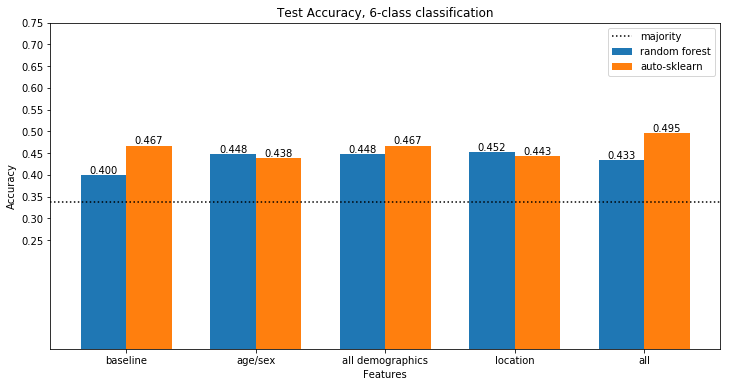

In [13]:
plot_results(rf_test_accs, automl_test_accs, majority_acc, "Accuracy", "Test Accuracy, 6-class classification")

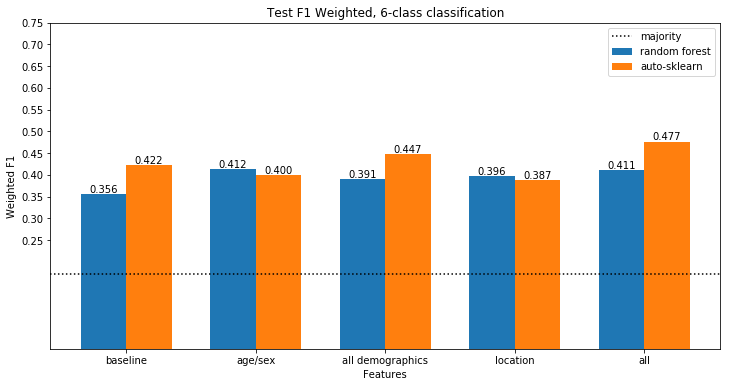

In [14]:
rf_f1 = [sk_metrics.f1_score(test_y, pred, average='weighted') for pred in rf_preds]
automl_f1 = [sk_metrics.f1_score(test_y, pred, average='weighted') for pred in automl_preds]
majority_f1 = sk_metrics.f1_score(test_y, [1] * len(test_y), average='weighted')

plot_results(rf_f1, automl_f1, majority_f1, "Weighted F1", "Test F1 Weighted, 6-class classification")

### AutoML model with all features

In [15]:
all_ensemble = automl_models[-1].get_models_with_weights()
print_ensemble(all_ensemble)

Weight: 0.38, classifier: adaboost
Weight: 0.28, classifier: adaboost
Weight: 0.14, classifier: xgradient_boosting
Weight: 0.04, classifier: gradient_boosting
Weight: 0.04, classifier: k_nearest_neighbors
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: liblinear_svc
Weight: 0.02, classifier: extra_trees
Weight: 0.02, classifier: gradient_boosting


In [16]:
print_confusion_matrix(test_y, automl_preds[-1], contact_types)

,p_work,p_friend,p_task,p_family_live_separate,p_family_live_together,p_sig_other
work,2,11,1,1,0,1
friend,3,51,1,14,0,2
task,0,4,15,0,0,0
family_live_separate,0,18,1,20,7,3
family_live_together,0,1,1,7,5,6
sig_other,0,7,1,9,7,11


## Results: contact type analysis

## Results: 4-class relationship prediction

In [43]:
replace_dict = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "family_live_separate": 1,
        "task": 2,
        "family_live_together": 3,
        "sig_other": 3
    }
}


predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]


train_data = top_5_baseline_train.replace(replace_dict)
test_data = top_5_baseline_test.replace(replace_dict)

test_y = test_data['contact_type']

contact_types_4clf = ['work', 'social', 'task', 'family_together']
rev_replace_dict = {idx:v for idx, v in enumerate(contact_types_4clf)}

In [54]:
train_data_4clf = train_data.replace({'contact_type': rev_replace_dict})

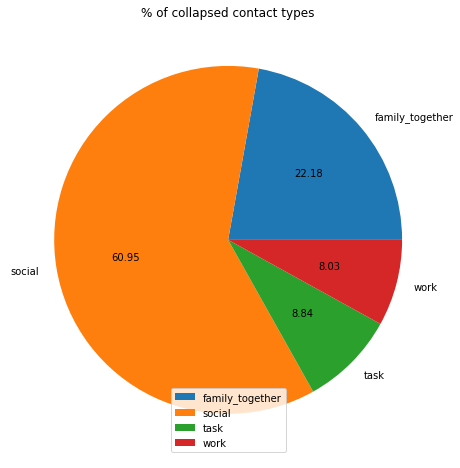

In [57]:
types_4clf = train_data_4clf.drop_duplicates('combined_hash').groupby('contact_type').count()
types_4clf.plot.pie('pid', autopct='%.2f', figsize=(8,8))
plt.title('% of collapsed contact types')
plt.legend(loc='lower center')
plt.ylabel("")
plt.show()

In [18]:
# load models

# random forest baseline
rf_models_4clf = []
rf_preds_4clf = []

for feat in features:
    with open("../model/rd3_results/top_5_contact_type_{}_rf_short.automl".format(feat), 'rb') as model_file:
        rf_models_4clf.append(pickle.load(model_file))
    with open("../model/rd3_results/top_5_contact_type_{}_rf_short.predict".format(feat), 'rb') as pred_file:
        rf_preds_4clf.append(pickle.load(pred_file))

In [40]:
# auto-sklearn models

automl_models_4clf = []
automl_preds_4clf = []

for feat in features[:-1]:
    with open("../model/rd3_results/top_5_contact_type_{}.automl".format(feat), 'rb') as model_file:
            automl_models_4clf.append(pickle.load(model_file))
    with open("../model/rd3_results/top_5_contact_type_{}.predict".format(feat), 'rb') as pred_file:
        automl_preds_4clf.append(pickle.load(pred_file))
        

with open("../model/rd3_results/top_5_contact_type_all_long.automl", 'rb') as model_file:
    automl_models_4clf.append(pickle.load(model_file))
with open("../model/rd3_results/top_5_contact_type_all_long.predict", 'rb') as pred_file:
    automl_preds_4clf.append(pickle.load(pred_file))

Could not delete output dir: /tmp/autosklearn_output_7287_5955
Could not delete tmp dir: /tmp/autosklearn_tmp_7287_5955
Could not delete output dir: /tmp/autosklearn_output_7025_5405
Could not delete tmp dir: /tmp/autosklearn_tmp_7025_5405
Could not delete output dir: /tmp/autosklearn_output_4720_1781
Could not delete tmp dir: /tmp/autosklearn_tmp_4720_1781
Could not delete output dir: /tmp/autosklearn_output_4832_1918
Could not delete tmp dir: /tmp/autosklearn_tmp_4832_1918
Could not delete output dir: /tmp/autosklearn_output_7052_5558
Could not delete tmp dir: /tmp/autosklearn_tmp_7052_5558


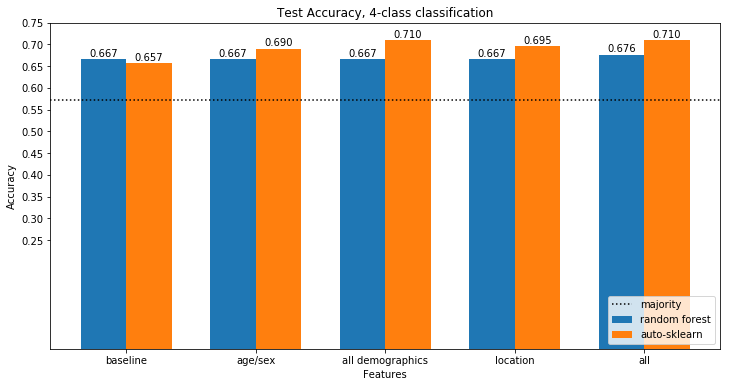

In [41]:
rf_acc_4clf = [sk_metrics.accuracy_score(test_y, pred) for pred in rf_preds_4clf]
automl_acc_4clf = [sk_metrics.accuracy_score(test_y, pred) for pred in automl_preds_4clf]
majority_acc_4clf = sk_metrics.accuracy_score(test_y, [1] * len(test_y))

plot_results(rf_acc_4clf, automl_acc_4clf, majority_acc_4clf, "Accuracy", "Test Accuracy, 4-class classification")

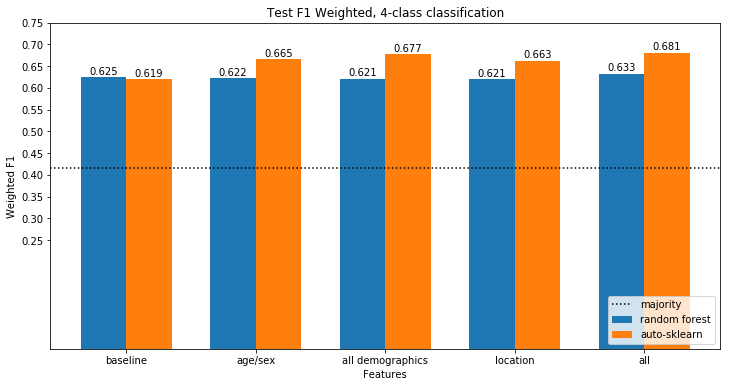

In [42]:
rf_f1_4clf = [sk_metrics.f1_score(test_y, pred, average='weighted') for pred in rf_preds_4clf]
automl_f1_4clf = [sk_metrics.f1_score(test_y, pred, average='weighted') for pred in automl_preds_4clf]
majority_f1_4clf = sk_metrics.f1_score(test_y, [1] * len(test_y), average='weighted')

plot_results(rf_f1_4clf, automl_f1_4clf, majority_f1_4clf, "Weighted F1", "Test F1 Weighted, 4-class classification")

In [36]:
all_ensemble = automl_models_4clf[-1].get_models_with_weights()
print_ensemble(all_ensemble)

print_confusion_matrix(test_y, automl_preds_4clf[-1], contact_types_4clf)

Weight: 0.36, classifier: adaboost
Weight: 0.12, classifier: xgradient_boosting
Weight: 0.04, classifier: gradient_boosting
Weight: 0.04, classifier: xgradient_boosting
Weight: 0.04, classifier: xgradient_boosting
Weight: 0.04, classifier: xgradient_boosting
Weight: 0.04, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: random_forest
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: xgradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: xgradient_boos

,p_work,p_social,p_task,p_family_together
work,1,15,0,0
social,0,106,1,13
task,0,7,11,1
family_together,0,23,1,31


# Outline

- intro/motivation
- methods
    - raw data features
    - feature extraction
    - autoML
- results
    - "original" task: confusion matrix, baseline, etc
    - communication label analysis: why the confusions are made
    - "collapsed" task: confusion matrix, baseline, etc
    - analysis of EMC results
- discussion
    - what we've learned about social support
    - caveats to autoML:
        - no block feature selection
        - no variable importance implemented (yet)
        - no ensemble size tuning
    - size of data:
        - can run additional analyses with round 2 of LifeSense study